# Preparing for analysis

## Importing Library

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
# from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures
import scipy 
from scipy import stats
import time
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator, DateFormatter
from statsmodels.tsa.api import VAR

## Importing Data

In [2]:
df_base = pd.read_excel("./RAW_DATA.xlsx")

In [3]:
df_base

,Date,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
0,2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
1,2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2,2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
3,2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
4,2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...,...
473,2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
474,2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
475,2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001
476,2023-11-05,170.289993,132.710007,34502.363281,106.120003,1996.199951,125.750000,59.419998,337.309998,4166.819824,4.875,19.750000


# Data Analysis

## Functions

[Function]Hist plot

In [50]:
# Function to create a histogram from a specified column in a DataFrame
def create_histogram(dataframe, column_name):
    """
    This function creates a histogram for a specified column from a DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column for which the histogram is to be created.

    Returns:
    A histogram plot for the specified column.
    """
    # Check if the column name exists in the DataFrame
    if column_name not in dataframe.columns:
        raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")

    # Plot the histogram
    dataframe[column_name].hist()
    plt.title(f"Histogram of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()


# Convert the 'Date' column to datetime and 'Value' to numeric, ignoring errors for conversion
# df = pd.DataFrame(data)
# df['Date'] = pd.to_datetime(df['Date'])
# df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Call the function with the example DataFrame and the 'Value' column
# create_histogram(df, 'Value')


[Function] Checking data: Normality

In [59]:
# データが正規分布に従っているかどうかを評価する関数
def evaluate_normality(data):
    # NaN値を削除
    data = data[~np.isnan(data)]
    
    # シャピロ-ウィルク テスト
    shapiro_test = stats.shapiro(data)
    print(f"Shapiro-Wilk Test: statistic={shapiro_test[0]}, p-value={shapiro_test[1]}")

    # アンダーソン-ダーリング テスト
    anderson_test = stats.anderson(data, dist='norm')
    print(f"Anderson-Darling Test: statistic={anderson_test.statistic}, significance_level={anderson_test.significance_level}, critical_values={anderson_test.critical_values}")

    # コルモゴロフ-スミルノフ テスト
    ks_test = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f"Kolmogorov-Smirnov Test: statistic={ks_test.statistic}, p-value={ks_test.pvalue}")

# サンプルデータを生成（ここでは正規分布を仮定している）
#sample_data = np.random.normal(loc=0, scale=1, size=100)

# データの正規性を評価
#evaluate_normality(sample_data)


[Function]Visualizing Linear data

In [9]:
def plot_stock_prices(title, dataframe, selected_columns, figsize=(20, 6)):
    """
    Plot stock prices from a dataframe.
    
    Parameters:
    - title: str, the title of the plot.
    - dataframe: pd.DataFrame containing date and stock prices.
    - selected_columns: list, the column names of stock prices to be plotted.
    - figsize: tuple, size of the figure to plot.
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Assuming the Date column is always named 'Date'
    for column in selected_columns:
        ax.plot(dataframe.index, dataframe[column], label=column)

    ax.set_title(f'Stock Price over Time({title})')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    
    # y軸の横の線を点線に設定
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, axis="y")
    # x軸の縦線を消す
    ax.grid(False, axis="x")
    
    # グラフの周りの四角い線を灰色に設定
    for spine in ax.spines.values():
        spine.set_color('gray')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=12))
    
    plt.style.use('tableau-colorblind10')
    plt.tight_layout()
    plt.show()

# 使用例
# selected_columns = ["Stock1", "Stock2"]
# plot_stock_prices('title', dataframe, selected_columns)

[Function]Making Portofolio

In [4]:
def calculate_efficient_frontier(temp_data, selected):
    # calculate daily and annual returns of the stocks
    returns_monthly = temp_data.pct_change()
    returns_annual = returns_monthly.mean() * 12

    # get daily and covariance of returns of the stock
    cov_monthly = returns_monthly.cov()
    cov_annual = cov_monthly * 12

    # 米国国債のリスクフリーレート
    rf_rate = 0.04849

    # empty lists to store returns, volatility and weights of imaginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = 5000

    np.random.seed(101)

    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = (returns - rf_rate) / volatility  # シャープレシオの計算を修正
        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)

    portfolio = {'Returns': port_returns,
                'Volatility': port_volatility,
                'Sharpe Ratio': sharpe_ratio}

    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

    df = pd.DataFrame(portfolio)
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]
    df = df[column_order]

    # 最大シャープレシオを持つポートフォリオを探す
    max_sharpe = df['Sharpe Ratio'].max()
    min_volatility = df['Volatility'].min()
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]

    print(sharpe_portfolio.T)
    print(min_variance_port.T)

    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200)
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier with Tangent Portfolio')
    plt.show()

# 使用例:
# calculate_efficient_frontier(temp_data, selected)

[Funstion]ADF test

In [6]:
def perform_adf_test_on_dataframe(df, alpha=0.05):
    # NaNの値を確認し、存在する場合はドロップ
    df.dropna(inplace=True)
    
    # 無限の値を確認し、存在する場合はNaNで置き換えてからドロップ
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    def adf_test(series):
        # 再度、シリーズにNaNまたは無限の値がないことを確認
        if series.isnull().sum() > 0 or np.isinf(series).sum() > 0:
            raise ValueError(f"Series contains NaN or infinite values")
            
        result = adfuller(series, autolag='AIC')
        test_statistic = result[0]
        p_value = result[1]
        lags_used = result[2]
        nobs = result[3]
        critical_values = result[4]
        result_dict = {
            "ADF Test Statistic": test_statistic,
            "P-Value": p_value,
            "# Lags Used": lags_used,
            "# Observations": nobs,
            "Result": "Stationary" if p_value <= alpha else "Not Stationary"
        }
        for key, value in critical_values.items():
            result_dict[f'Critical Value ({key})'] = value
        return result_dict
    
    results = {col: adf_test(df[col]) for col in df.columns if col != 'Date'}
    return pd.DataFrame(results).T



# Example usage:
# df_results = perform_adf_test_on_dataframe(df_stock_mo)
# display(df_results)

[Function]Deleting Stationality eith diff

In [5]:
def remove_trend_diff(data) -> pd.DataFrame:
    """
    Apply differencing and drop NaN rows to remove trend non-stationarity from time series data.
    
    Parameters:
    - data: pd.Series or pd.DataFrame, the input data with one or more time series columns.

    Returns:
    - pd.Series or pd.DataFrame, the transformed data with trend non-stationarity removed.
    """
    
    if isinstance(data, pd.Series):
        data_copy = data.copy()
        return data_copy.diff().dropna()
    
    elif isinstance(data, pd.DataFrame):
        data_copy = data.copy()
        
        # List all columns except 'Date'
        cols_to_diff = [col for col in data_copy.columns if col != 'Date']
        
        # Apply diff() for each column except 'Date'
        for col in cols_to_diff:
            data_copy[col] = data_copy[col].diff()
        
        # Drop rows with NaN values
        return data_copy.dropna()
    
    else:
        raise ValueError("Input data must be a pandas DataFrame or Series")
      
# remove_trend_diff(dataframe)

[Function]Deliting Stationality with Log transformation

In [7]:
def remove_trend_log(data, selected_columns=None) -> pd.DataFrame:
    """
    Compute the log difference for a given DataFrame or Series.
    
    Parameters:
    - data: pd.DataFrame or pd.Series, the input data with one or more time series columns.
    - selected_columns: list, the columns for which the log difference should be computed.
                    If None, it computes for all columns (except 'Date' if present).

    Returns:
    - pd.DataFrame or pd.Series, the log difference of the original data.
    """
    
    # If data is a Series
    if isinstance(data, pd.Series):
        return np.log(data).diff().dropna()
    
    # If data is a DataFrame
    elif isinstance(data, pd.DataFrame):
        
        # If no specific columns are selected, select all columns except 'Date'
        if selected_columns is None:
            selected_columns = [col for col in data.columns if col != 'Date']
        
        # Apply log difference for each selected column
        for col in selected_columns:
            data[col] = np.log(data[col]).diff()
        
        return data.dropna()
    
    else:
        raise ValueError("Input data must be a pandas DataFrame or Series")

# Example usage
# df_log_diff = remove_trend_log(dataframe, ['Column1', 'Column2'])

[Function]VAR model

In [ ]:
'''---- VARモデル -----'''
def create_var_model(data, lags=None):
    """
    データフレームを入力として受け取り、指定されたラグ数でVARモデルをフィットさせる関数
    
    Parameters:
    - data (pd.DataFrame): 多変量の時系列データ
    - lags (int, optional): モデルに使用するラグ数。指定されていない場合、自動的に選択されます。
    
    Returns:
    - model: フィットされたVARモデル
    """

    model = VAR(data)
    
    if lags:
        result = model.fit(lags)
    else:
        result = model.fit(maxlags=12, ic='aic')  # maxlagsと情報量基準(ic)を指定して自動的にラグ数を選択

    return result

# 例:
# data = pd.DataFrame({
#     'y1': np.random.randn(100),
#     'y2': np.random.randn(100)
# })
# fitted_model = create_var_model(data)
# print(fitted_model.summary())


[Function]Forcasting with VAR model

In [8]:

'''---- VARモデルでの予測 ----'''
def plot_var_forecast_for_target(data, target='7203.T', forecast_steps=10, lags=None):
    """
    VARモデルを用いて特定のターゲット変数の予測をグラフで表示する関数
    
    Parameters:
    - data (pd.DataFrame): VARモデルの入力データ
    - target (str): 予測対象のカラム名
    - forecast_steps (int): 予測を行うステップ数
    
    Returns:
    None (グラフを表示する)
    """
    
    # VARモデルをデータに適用
    model = VAR(data)
    if lags:
        fitted_model = model.fit(lags)
    else:
        fitted_model = model.fit(maxlags=12, ic='aic')  # maxlagsと情報量基準(ic)を指定して自動的にラグ数を選択
    fitted_model = model.fit()

    # 予測の生成
    forecast = fitted_model.forecast(data.values[-fitted_model.k_ar:], steps=forecast_steps)
    forecast_df = pd.DataFrame(forecast, columns=data.columns)

    # 予測結果のグラフ表示
    plt.figure(figsize=(10, 6))
    plt.plot(data[target], label='Actual', color='blue')
    plt.plot(np.arange(len(data), len(data) + forecast_steps), forecast_df[target], label='Forecast', color='red')
    plt.title(f'Forecast for {target}')
    plt.legend()
    plt.grid(True)
    plt.show()

# 使用例:
# data = pd.DataFrame({
#     '7203.T': np.random.randn(100),
#     '7201.T': np.random.randn(100)
# })
# plot_var_forecast_for_target(data, target='7203.T', forecast_steps=30)

[Function]VAR eith Montecarlo

In [129]:
import numpy as np
import pandas as pd

def calculate_var(df, price_column, initial_price, confidence_level=0.95, num_simulations=10000, time_horizon=1):
    """
    モンテカルロシミュレーションを使用してVaRを計算する関数。

    Parameters:
    df (DataFrame): 収益率の計算に使用する価格データが含まれるDataFrame。
    price_column (str): 収益率の計算に使用する価格データが含まれる列の名前。
    initial_price (float): Bitcoin購入時の価格。
    confidence_level (float): VaRの信頼水準。
    num_simulations (int): シミュレーションの回数。
    time_horizon (int): 価格を予測する期間（週数）。

    Returns:
    float: 計算されたVaRの値。
    """

    # 'Price' 列から 'returns' 列を計算する
    df['returns'] = df[price_column].pct_change().dropna()
    
    # 収益率の統計量を計算
    mean_return = df['returns'].mean()
    std_dev_return = df['returns'].std()

    # シミュレーションされた価格を格納する配列
    simulated_end_prices = []

    # モンテカルロシミュレーションを実行
    for _ in range(num_simulations):
        # 正規分布からランダムな収益率を生成
        random_returns = np.random.normal(mean_return, std_dev_return, time_horizon)
        # 最終価格を計算
        end_price = initial_price * np.prod(1 + random_returns)
        simulated_end_prices.append(end_price)

    # 損失を計算
    losses = initial_price - np.array(simulated_end_prices)

    # VaRの計算
    var = np.percentile(losses, (1 - confidence_level) * 100)
    return var

# 使用例:
# df = pd.read_csv('path_to_your_bitcoin_data.csv')
# 1週間のVaRを計算する場合
# calculated_var = calculate_var(df, 'Price_Column_Name', 8000, time_horizon=1)
# 4週間のVaRを計算する場合
# calculated_var = calculate_var(df, 'Price_Column_Name', 8000, time_horizon=4)
# print(f"4週間のVaR（信頼水準 {confidence_level * 100}%）: ¥{calculated_var:.2f}")


[Function]Make Portfolio

In [211]:
df_main = df_base.copy()
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main.set_index('Date', inplace=True)
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
Date,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001


In [212]:
df_main.columns

Index(['AAPL', 'AMZN', 'BTC-USD', 'DX-Y.NYB', 'GC=F', 'GOOG', 'MET', 'MSFT',
       '^GSPC', '^TNX', '^VIX'],
      dtype='object')

                       95
Returns          0.342787
Volatility       0.293516
Sharpe Ratio     1.008487
BTC-USD Weight   0.367515
DX-Y.NYB Weight  0.007037
GC=F Weight      0.342247
^GSPC Weight     0.069121
^TNX Weight      0.214081
                     4370
Returns          0.051734
Volatility       0.045575
Sharpe Ratio     0.108689
BTC-USD Weight   0.006998
DX-Y.NYB Weight  0.635765
GC=F Weight      0.202010
^GSPC Weight     0.145285
^TNX Weight      0.009942


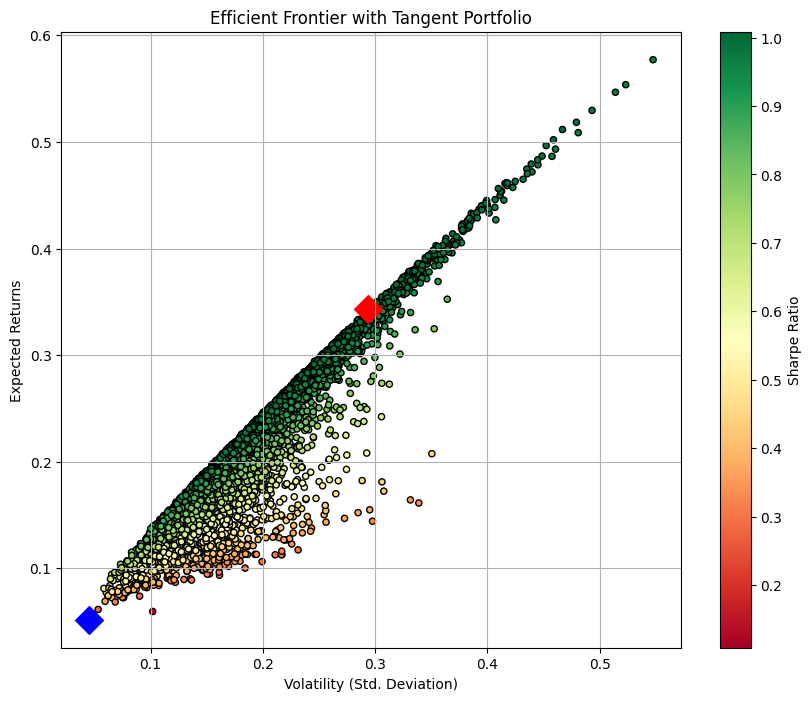

In [219]:
# get prices data
selected = [
            'BTC-USD',
            'DX-Y.NYB',
            'GC=F',
            '^GSPC',
            '^TNX',
            # '^VIX'
            ]
temp_data = df_main[selected]

# calculate daily and annual returns of the stocks
returns_weekly = temp_data.pct_change()
returns_annual = returns_weekly.mean() * 53

# get daily and covariance of returns of the stock
cov_weekly = returns_weekly.cov()
cov_annual = cov_weekly * 53

# 日本国債のリスクフリーレート
rf_rate = 0.04678

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 5000

np.random.seed(101)

for single_portfolio in range(num_portfolios):
   weights = np.random.random(num_assets)
   weights /= np.sum(weights)
   returns = np.dot(weights, returns_annual)
   volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
   sharpe = (returns - rf_rate) / volatility  # シャープレシオの計算を修正
   sharpe_ratio.append(sharpe)
   port_returns.append(returns)
   port_volatility.append(volatility)
   stock_weights.append(weights)

portfolio = {'Returns': port_returns,
            'Volatility': port_volatility,
            'Sharpe Ratio': sharpe_ratio}

for counter,symbol in enumerate(selected):
   portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

df = pd.DataFrame(portfolio)
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]
df = df[column_order]

# 最大シャープレシオを持つポートフォリオを探す
max_sharpe = df['Sharpe Ratio'].max()
min_volatility = df['Volatility'].min()
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

print(sharpe_portfolio.T)
print(min_variance_port.T)

# plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
               cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier with Tangent Portfolio')
plt.show()

## Visualizing Data

In [90]:
df_main = df_base.copy()
df_main

,Date,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
0,2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
1,2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2,2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
3,2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
4,2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...,...
473,2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
474,2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
475,2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001
476,2023-11-05,170.289993,132.710007,34502.363281,106.120003,1996.199951,125.750000,59.419998,337.309998,4166.819824,4.875,19.750000


In [91]:
# 仮定として、df は上記のデータを含む pandas DataFrame です。
# まず、Date カラムのデータ型を datetime に変換します。
df_main['Date'] = pd.to_datetime(df_main['Date'])

# 次に、Date カラムをインデックスに設定します。
df_main.set_index('Date', inplace=True)

In [92]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
Date,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001


In [93]:
df_main.describe()

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,80.442343,88.376984,14167.779437,96.948013,1497.278663,71.002488,50.492607,154.663703,3064.837382,2.259270,18.652594
std,54.875394,49.587882,16014.117492,4.926570,295.098650,36.284469,10.102092,97.926096,868.202615,0.890549,7.686478
min,23.010000,14.498500,210.494995,84.669998,1064.699951,24.560070,23.530001,40.959999,1853.439941,0.499000,9.340000
25%,32.553750,40.699874,849.357498,93.757498,1238.950012,39.799250,44.628100,62.655000,2258.352478,1.672250,13.492500
50%,51.142500,88.763748,8190.559814,96.555000,1338.199951,58.670750,47.779999,119.884998,2843.739990,2.219500,16.465000
75%,135.237495,128.540501,22691.929199,99.357500,1798.624969,101.749622,59.257501,244.067505,3932.187561,2.822250,22.199999
max,196.449997,185.927505,67566.828125,114.099998,2026.300049,149.388000,75.889999,356.529999,4796.560059,4.875000,82.690002


In [94]:
df_main.columns

Index(['AAPL', 'AMZN', 'BTC-USD', 'DX-Y.NYB', 'GC=F', 'GOOG', 'MET', 'MSFT',
       '^GSPC', '^TNX', '^VIX'],
      dtype='object')

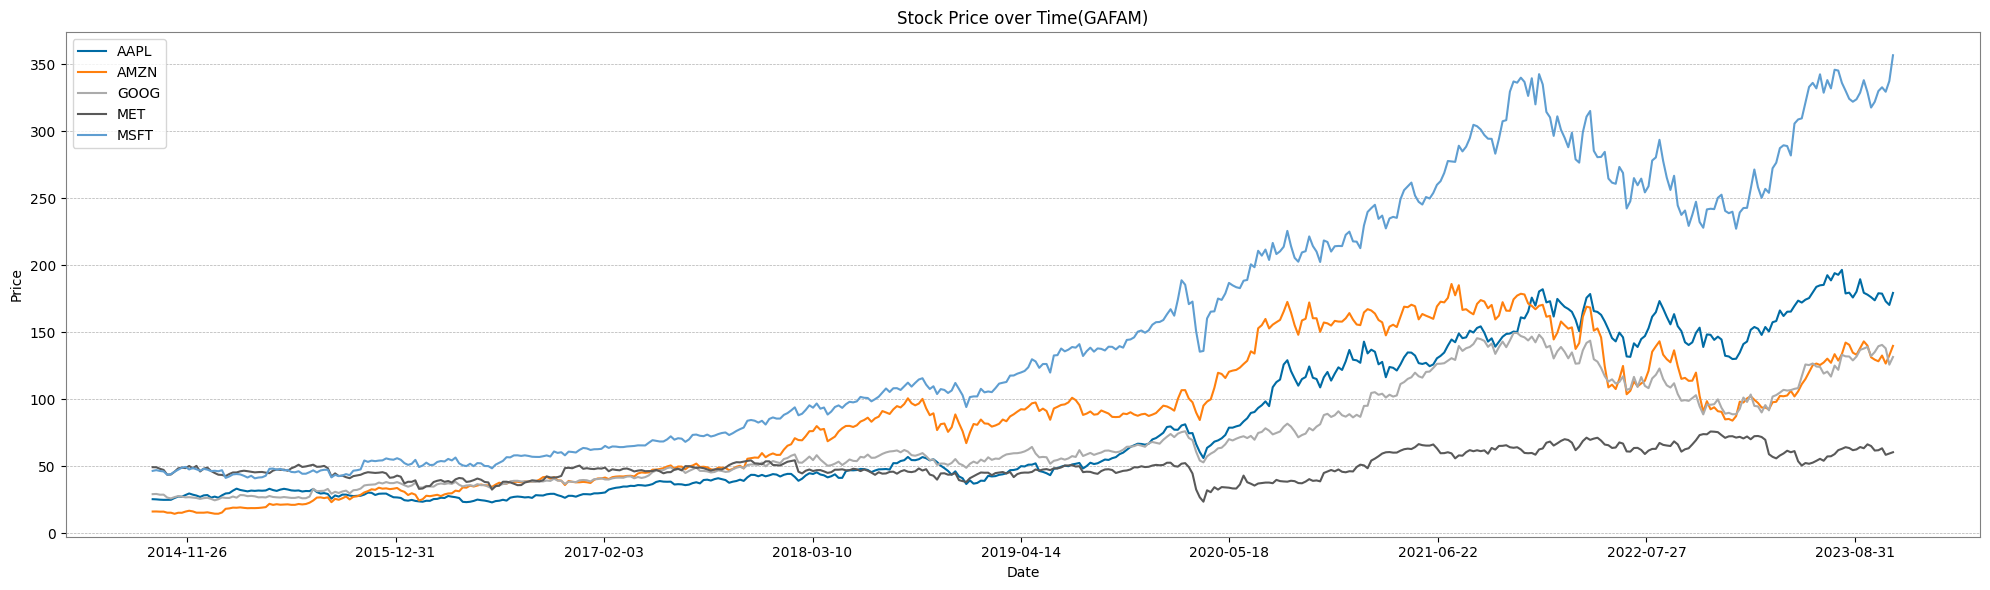

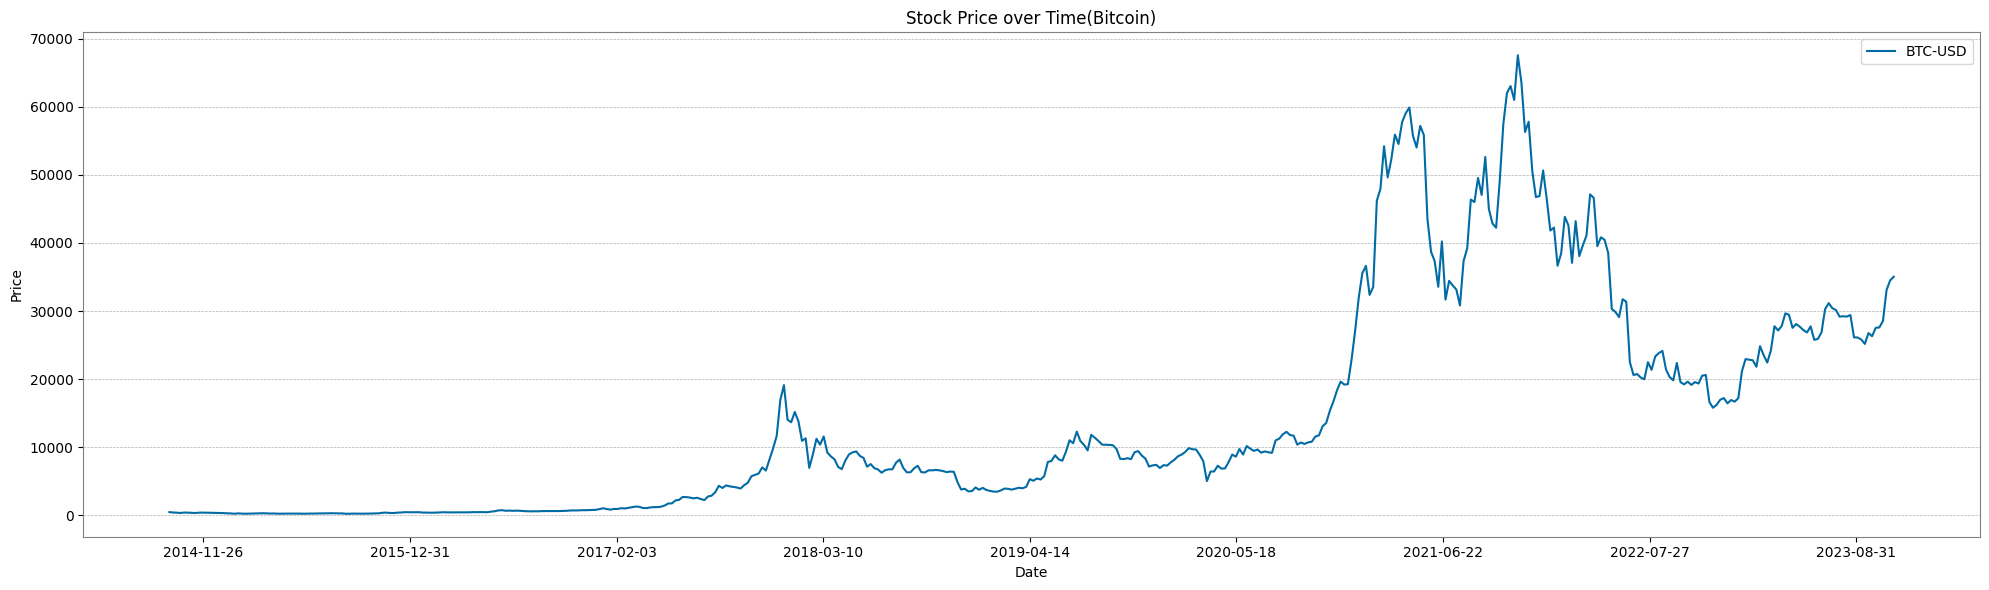

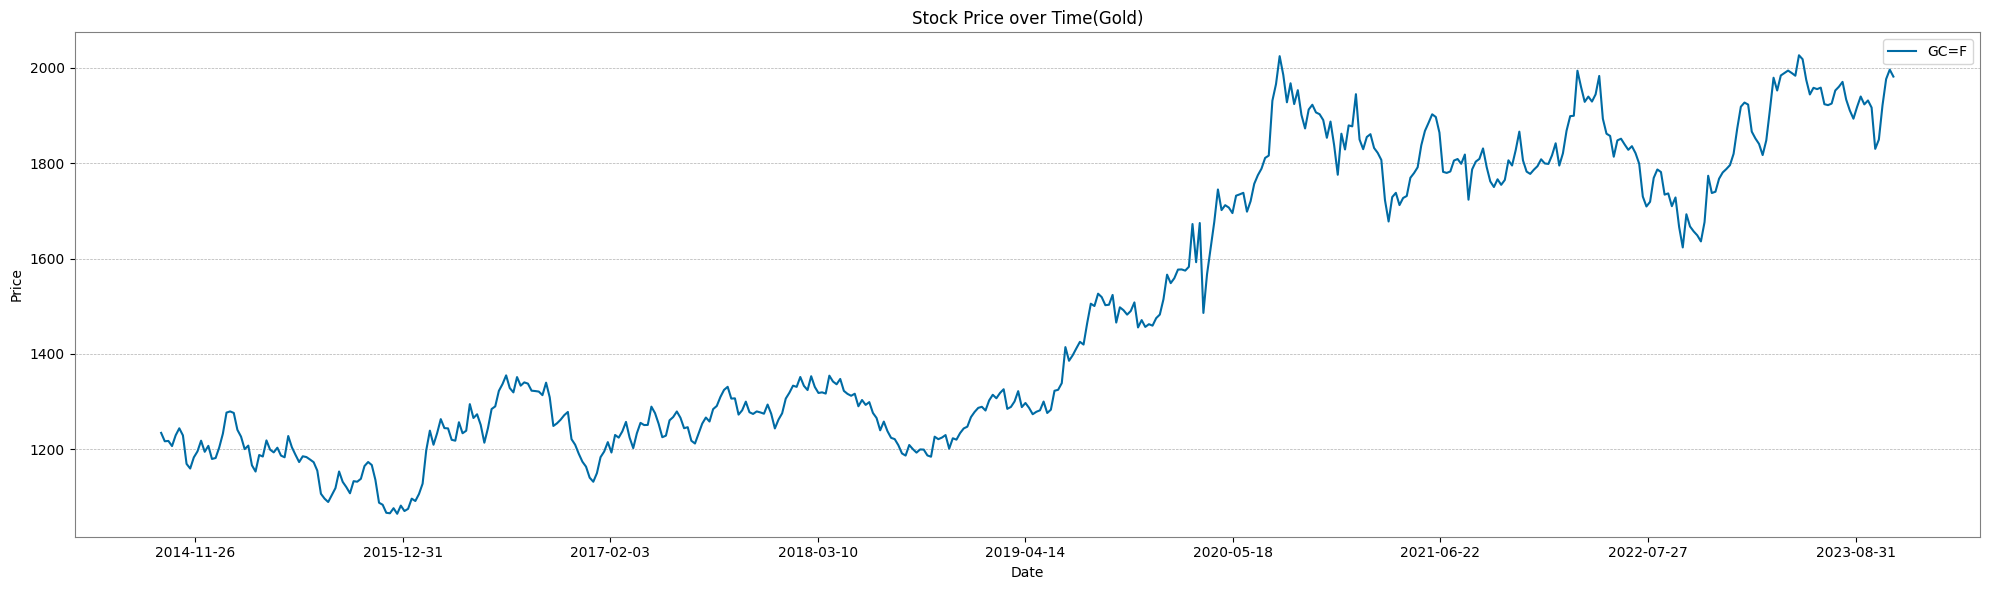

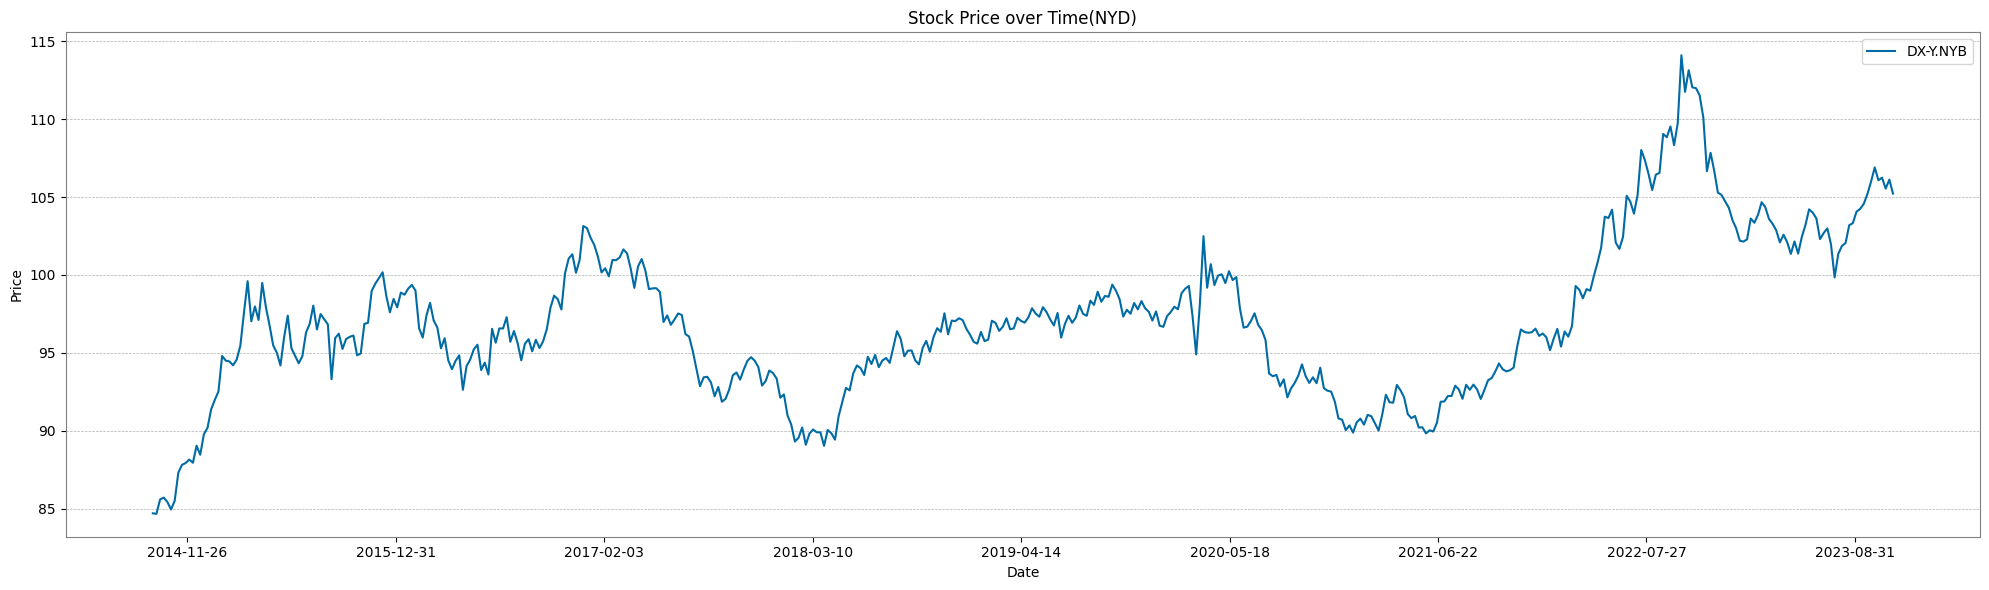

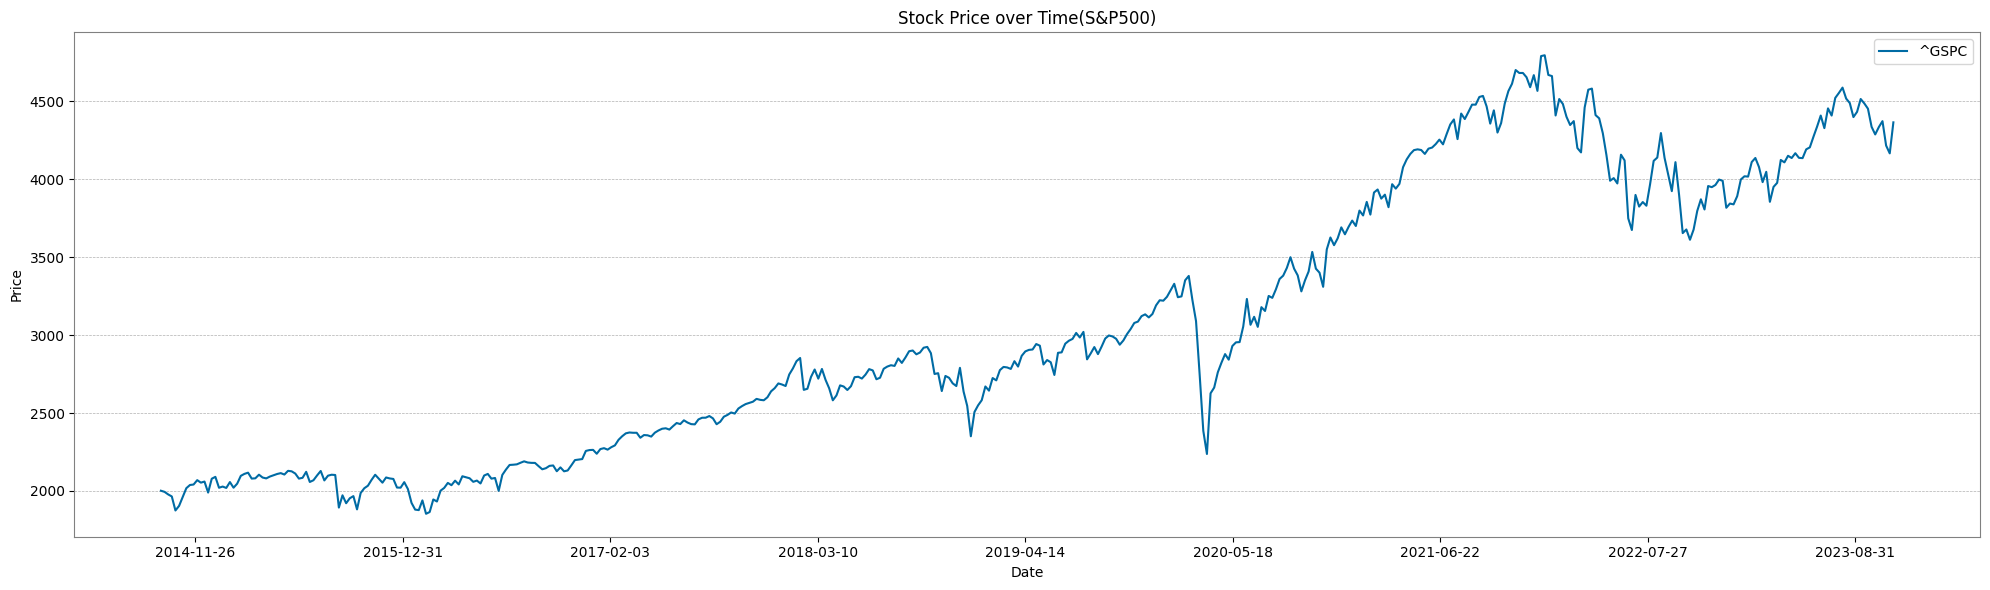

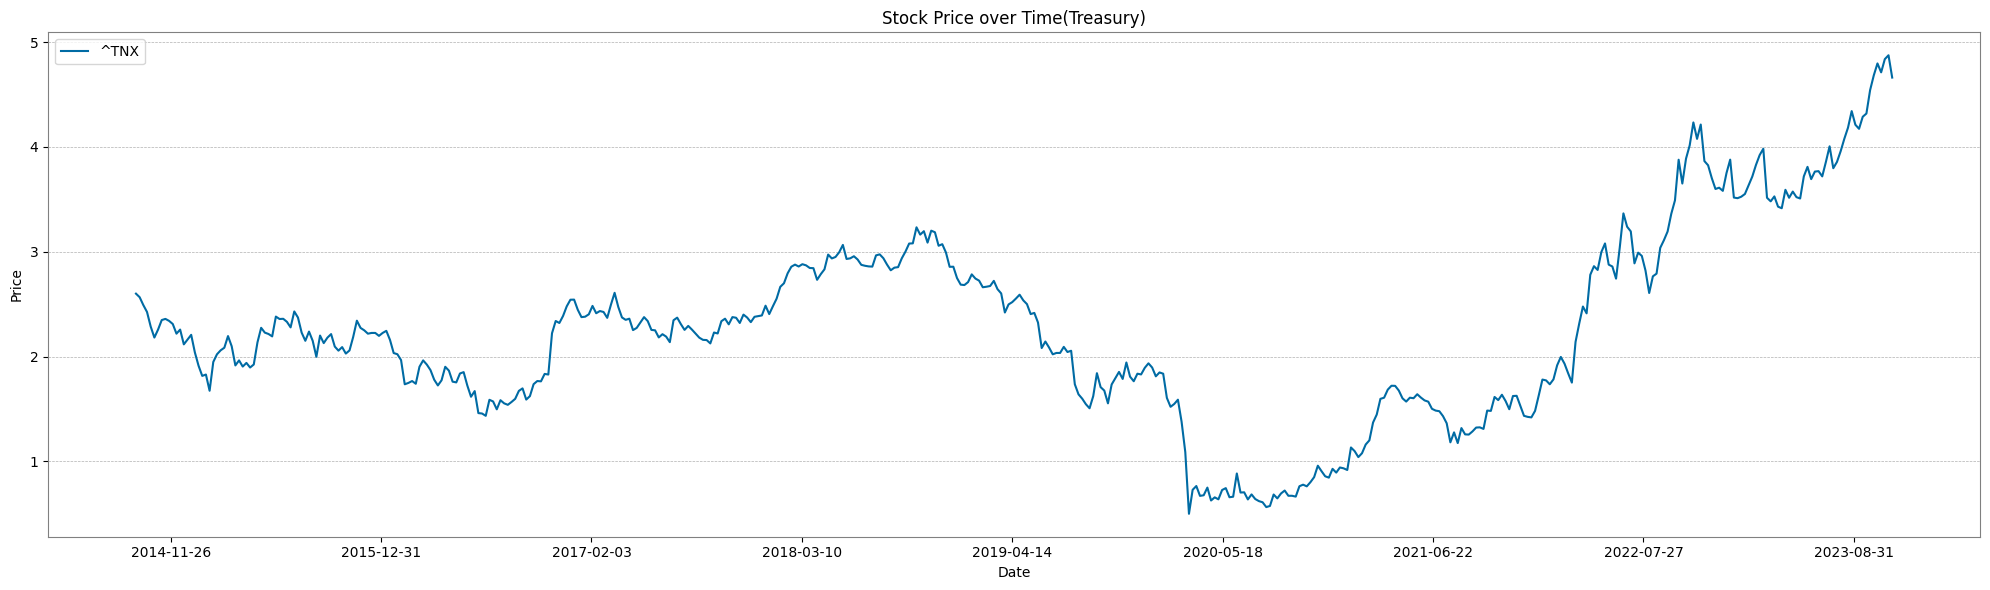

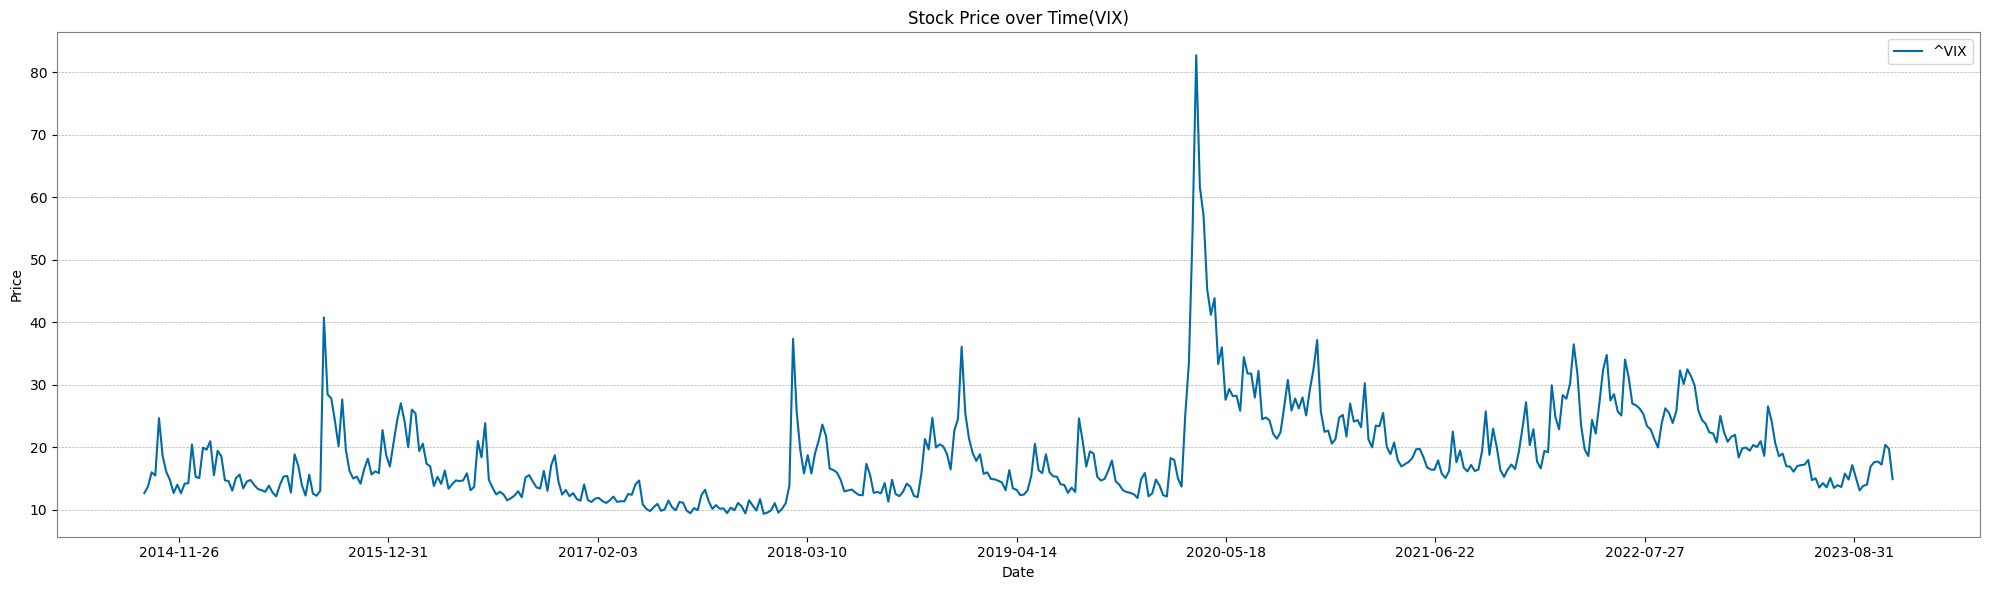

In [71]:
columns_GAFAM = ["AAPL", "AMZN", "GOOG", 'MET', "MSFT", ]
columns_Material = ['GC=F'] # 金
columns_NYD = ['DX-Y.NYB'] # NYD
columns_SP = ["^GSPC"] # S&P500
columns_Tresury = ["^TNX"] # 10年米国債
columns_VIX = ["^VIX"] # CBOE(投資の先行き不安の指数)
columns_Bitcoin = ['BTC-USD']


# GAFAM--------------
plot_stock_prices('GAFAM', df_main, columns_GAFAM)
# Bitcoin--------------
plot_stock_prices('Bitcoin', df_main, columns_Bitcoin)
# Gold--------------
plot_stock_prices('Gold', df_main, columns_Material)
# NYD--------------
plot_stock_prices('NYD', df_main, columns_NYD)
# SP--------------
plot_stock_prices('S&P500', df_main, columns_SP)
# Tresury--------------
plot_stock_prices('Treasury', df_main, columns_Tresury)
# VIX--------------
plot_stock_prices('VIX', df_main, columns_VIX)


## Quantifying the risk of Bitcoin with VAR

In [96]:
# 2. 収益率の計算
# Bitcoinの価格を基に収益率を計算します。ここでは 'Price' 列が価格データを含んでいると仮定しています。
df_main['return_BTC'] = df_main['BTC-USD'].pct_change()

In [97]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,return_BTC
Date,,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000,NaN
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000,-0.120660
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000,-0.066355
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000,-0.120884
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999,0.182790
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001,0.001921
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999,0.033925
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001,0.160128


In [122]:
df_bitcoin = df_main[['BTC-USD', 'return_BTC']]

In [123]:
df_bitcoin

,BTC-USD,return_BTC
Date,,
2014-09-21,457.334015,NaN
2014-09-28,402.152008,-0.120660
2014-10-05,375.467010,-0.066355
2014-10-12,330.079010,-0.120884
2014-10-19,390.414001,0.182790
...,...,...
2023-10-15,27583.677734,0.001921
2023-10-22,28519.466797,0.033925
2023-10-29,33086.234375,0.160128


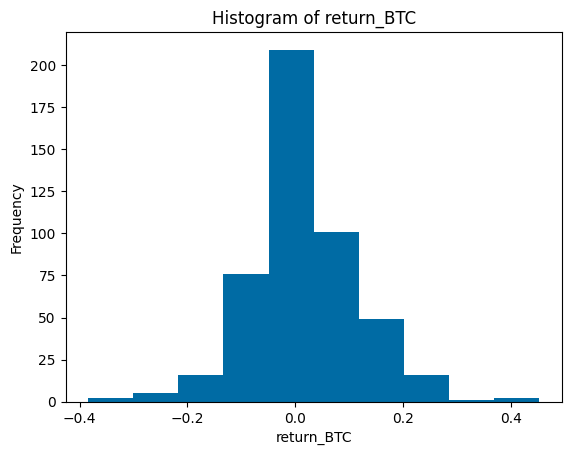

In [103]:
create_histogram(df_bitcoin, 'return_BTC')

In [104]:
evaluate_normality(df_bitcoin['return_BTC'])

Shapiro-Wilk Test: statistic=0.966593861579895, p-value=5.939018610234825e-09
Anderson-Darling Test: statistic=5.049716551951974, significance_level=[15.  10.   5.   2.5  1. ], critical_values=[0.571 0.651 0.781 0.91  1.083]
Kolmogorov-Smirnov Test: statistic=0.08489076101883963, p-value=0.0019375256416727773


In [87]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,return_BTC
Date,,,,,,,,,,,,
2014-11-23,28.497499,16.152500,387.407990,87.930000,1183.000000,26.752052,48.565063,49.459999,2041.319946,2.340,13.990000,-0.766864
2015-03-01,33.250000,19.007000,238.891998,94.570000,1200.300049,26.522682,45.329769,44.150002,2109.659912,2.059,14.560000,-1.061135
2015-03-08,32.272499,19.283001,275.670013,95.459999,1207.699951,28.488785,46.185383,43.880001,2117.389893,2.084,13.040000,1.964349
2015-03-15,31.785000,18.927999,289.606995,97.589996,1166.400024,28.364626,46.639931,42.849998,2079.429932,2.195,15.060000,-1.113547
2015-03-22,31.237499,18.667500,290.592987,99.599998,1153.300049,27.649588,46.274509,41.560001,2081.189941,2.098,15.610000,-2.697973
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001,-3.194172
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999,2.871208
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001,1.551808


In [88]:
evaluate_normality(df_main['return_BTC'])

Shapiro-Wilk Test: statistic=nan, p-value=1.0
Anderson-Darling Test: statistic=nan, significance_level=[15.  10.   5.   2.5  1. ], critical_values=[0.561 0.639 0.767 0.894 1.064]
Kolmogorov-Smirnov Test: statistic=nan, p-value=nan


## VAR for Bitcoin

In [124]:
df_bitcoin

,BTC-USD,return_BTC
Date,,
2014-09-21,457.334015,NaN
2014-09-28,402.152008,-0.120660
2014-10-05,375.467010,-0.066355
2014-10-12,330.079010,-0.120884
2014-10-19,390.414001,0.182790
...,...,...
2023-10-15,27583.677734,0.001921
2023-10-22,28519.466797,0.033925
2023-10-29,33086.234375,0.160128


In [232]:
df_main.tail()

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,returns
Date,,,,,,,,,,,,
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001,0.011023
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999,0.008758
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001,-0.035803
2023-11-05,170.289993,132.710007,34502.363281,106.120003,1996.199951,125.750000,59.419998,337.309998,4166.819824,4.875,19.750000,-0.011909
2023-11-12,179.229996,139.740005,35037.371094,105.220001,1981.599976,131.449997,60.430000,356.529999,4365.979980,4.662,14.890000,0.047797


In [230]:
# 2017年9月のデータを検索
df_main.loc['2017-09']

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,returns
Date,,,,,,,,,,,,
2017-09-03,40.367500,47.300999,4382.660156,92.209999,1309.699951,45.690498,47.570000,72.830002,2444.239990,2.159,11.32,0.006535
2017-09-10,41.012501,48.912498,4236.310059,92.809998,1324.500000,46.867001,47.799999,73.940002,2476.550049,2.157,10.13,0.013219
2017-09-17,40.375000,48.897999,4161.270020,91.860001,1331.000000,46.453999,47.590000,74.760002,2488.110107,2.125,10.73,0.004668
2017-09-24,39.667500,48.709499,4065.199951,92.050003,1306.300049,45.750000,48.900002,75.160004,2503.870117,2.229,10.15,0.006334


In [233]:
# 使用例:
confidence_level = 0.95
# 1週間のVaRを計算する場合
calculated_var_w1 = calculate_var(df_bitcoin, 'BTC-USD', 4300, time_horizon=1)
# 4週間のVaRを計算する場合
calculated_var_w4 = calculate_var(df_bitcoin, 'BTC-USD', 4300, time_horizon=4)
# 16週間のVaRを計算する場合
calculated_var_w16 = calculate_var(df_bitcoin, 'BTC-USD', 4300, time_horizon=16)

print("---------------")
print(f"VaR for 1 week（信頼水準 {confidence_level * 100}%）: ${calculated_var_w1:.2f}")
print("---------------")
print(f"VaR for 4 weeks（信頼水準 {confidence_level * 100}%）: ${calculated_var_w4:.2f}")
print("---------------")
print(f"VaR for 16 weeks（信頼水準 {confidence_level * 100}%）: ${calculated_var_w16:.2f}")

---------------
VaR for 1 week（信頼水準 95.0%）: $-760.79
---------------
VaR for 4 weeks（信頼水準 95.0%）: $-1807.28
---------------
VaR for 16 weeks（信頼水準 95.0%）: $-5316.79


In [234]:
# 使用例:
confidence_level = 0.95
# 1週間のVaRを計算する場合
calculated_var_w1 = calculate_var(df_main, '^GSPC', 4300, time_horizon=1)
# 4週間のVaRを計算する場合
calculated_var_w4 = calculate_var(df_main, '^GSPC', 4300, time_horizon=4)
# 16週間のVaRを計算する場合
calculated_var_w16 = calculate_var(df_main, '^GSPC', 4300, time_horizon=16)

print("---------------")
print(f"VaR for 1 week（信頼水準 {confidence_level * 100}%）: ${calculated_var_w1:.2f}")
print("---------------")
print(f"VaR for 4 weeks（信頼水準 {confidence_level * 100}%）: ${calculated_var_w4:.2f}")
print("---------------")
print(f"VaR for 16 weeks（信頼水準 {confidence_level * 100}%）: ${calculated_var_w16:.2f}")

---------------
VaR for 1 week（信頼水準 95.0%）: $-185.23
---------------
VaR for 4 weeks（信頼水準 95.0%）: $-384.59
---------------
VaR for 16 weeks（信頼水準 95.0%）: $-886.68


## ADF test

In [148]:
df_main = df_base.copy()
df_main.head()

,Date,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
0,2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
1,2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2,2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
3,2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
4,2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999


In [143]:
# Example usage:
df_results = perform_adf_test_on_dataframe(df_main)
display(df_results)

,ADF Test Statistic,P-Value,# Lags Used,# Observations,Result,Critical Value (1%),Critical Value (5%),Critical Value (10%)
AAPL,0.048536,0.962367,1,476,Not Stationary,-3.444163,-2.867631,-2.570014
AMZN,-1.291484,0.633059,0,477,Not Stationary,-3.444134,-2.867618,-2.570008
BTC-USD,-1.255666,0.649203,0,477,Not Stationary,-3.444134,-2.867618,-2.570008
DX-Y.NYB,-2.450632,0.127953,1,476,Not Stationary,-3.444163,-2.867631,-2.570014
GC=F,-0.644148,0.860691,1,476,Not Stationary,-3.444163,-2.867631,-2.570014
GOOG,-0.406984,0.908926,1,476,Not Stationary,-3.444163,-2.867631,-2.570014
MET,-1.838495,0.361524,5,472,Not Stationary,-3.444281,-2.867683,-2.570042
MSFT,0.492202,0.984634,2,475,Not Stationary,-3.444192,-2.867644,-2.570021
^GSPC,-0.78606,0.823182,0,477,Not Stationary,-3.444134,-2.867618,-2.570008
^TNX,-0.012315,0.957502,0,477,Not Stationary,-3.444134,-2.867618,-2.570008


## Johansen Test

In [154]:
numeric_columns = ['AAPL', 'AMZN', 'BTC-USD', 'DX-Y.NYB', 'GC=F', 'GOOG', 'MET', 'MSFT', '^GSPC', '^TNX']
df_diff = remove_trend_diff(df_main[numeric_columns])
df_diff = df_diff.join(df_main["^VIX"], how='outer')
df_diff = df_diff.dropna()
df_diff

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
1,-0.130001,0.025000,-55.182007,-0.029999,-17.599976,0.129644,-0.053474,0.540001,-7.279907,-0.034,13.690000
2,-0.237499,-0.134001,-26.684998,0.919998,0.699951,-0.548992,-1.167561,-0.620003,-16.489990,-0.075,15.980000
3,-0.122499,0.019001,-45.388000,0.120003,-10.800049,0.049364,-0.819962,-0.349998,-12.980103,-0.066,15.460000
4,0.047499,-0.787500,60.334991,-0.279999,22.600098,-2.200958,-3.582890,-2.439999,-90.079956,-0.139,24.639999
5,-0.012499,-0.012000,-7.569000,-0.480003,14.699951,-0.616806,0.160427,0.430000,29.270020,-0.105,18.570000
...,...,...,...,...,...,...,...,...,...,...,...
473,5.240005,-1.200012,52.892578,-0.820000,19.500000,4.330002,0.210003,8.020020,47.270020,0.114,17.700001
474,-0.270004,4.290009,935.789062,0.159996,71.599976,0.990005,1.449997,2.820007,37.969727,-0.085,17.209999
475,-5.720001,-5.990005,4566.767578,-0.699997,55.200073,-2.590012,-4.859997,-3.320007,-156.589844,0.126,20.370001
476,-2.710007,6.150009,1416.128906,0.580002,19.899902,-12.149994,0.929996,7.989990,-50.220215,0.037,19.750000


In [155]:
df_results = perform_adf_test_on_dataframe(df_diff)
display(df_results)

,ADF Test Statistic,P-Value,# Lags Used,# Observations,Result,Critical Value (1%),Critical Value (5%),Critical Value (10%)
AAPL,-23.370989,0.0,0,476,Stationary,-3.444163,-2.867631,-2.570014
AMZN,-21.513914,0.0,0,476,Stationary,-3.444163,-2.867631,-2.570014
BTC-USD,-21.014493,0.0,0,476,Stationary,-3.444163,-2.867631,-2.570014
DX-Y.NYB,-23.856012,0.0,0,476,Stationary,-3.444163,-2.867631,-2.570014
GC=F,-23.371974,0.0,0,476,Stationary,-3.444163,-2.867631,-2.570014
GOOG,-24.373268,0.0,0,476,Stationary,-3.444163,-2.867631,-2.570014
MET,-11.144277,0.0,4,472,Stationary,-3.444281,-2.867683,-2.570042
MSFT,-16.911565,0.0,1,475,Stationary,-3.444192,-2.867644,-2.570021
^GSPC,-11.240106,0.0,4,472,Stationary,-3.444281,-2.867683,-2.570042
^TNX,-20.975875,0.0,0,476,Stationary,-3.444163,-2.867631,-2.570014


In [158]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# まずはデータフレームから数値データのみを選択します。
# ここでは 'df' が元のデータフレームで、数値データのみを含む列名のリストを 'numeric_columns' とします。
numeric_columns = ['AAPL', 'AMZN', 'BTC-USD', 'DX-Y.NYB', 'GC=F', 'GOOG', 'MET', 'MSFT', '^GSPC', '^TNX']
df_numeric = df_main[numeric_columns]

# 次に、数値データのみを含むデータフレームの1階差分を取ります。
df_diff = df_numeric.diff().dropna()

# Johansen共和分検定を行います。
johansen_test = coint_johansen(df_diff, det_order=-1, k_ar_diff=1)

# 共和分検定の結果を表示します。
print(johansen_test.trace_stat)
print(johansen_test.trace_stat_crit_vals)
print(johansen_test.max_eig_stat)
print(johansen_test.max_eig_stat_crit_vals)

[4394.02796901 3865.20700239 3363.12662052 2876.5173206  2392.46417151
 1959.24644077 1528.98338    1121.37814186  730.42551664  355.03670334]
[[212.4721 219.4051 232.8291]
 [173.2292 179.5199 191.8122]
 [137.9954 143.6691 154.7977]
 [106.7351 111.7797 121.7375]
 [ 79.5329  83.9383  92.7136]
 [ 56.2839  60.0627  67.6367]
 [ 37.0339  40.1749  46.5716]
 [ 21.7781  24.2761  29.5147]
 [ 10.4741  12.3212  16.364 ]
 [  2.9762   4.1296   6.9406]]
[528.82096662 502.08038187 486.60929992 484.05314909 433.21773074
 430.26306077 407.60523814 390.95262522 375.3888133  355.03670334]
[[57.7954 61.0404 67.6415]
 [51.8528 54.9629 61.3449]
 [45.893  48.8795 55.0335]
 [39.9085 42.7679 48.6606]
 [33.9271 36.6301 42.2333]
 [27.916  30.4428 35.7359]
 [21.837  24.1592 29.0609]
 [15.7175 17.7961 22.2519]
 [ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]


In [160]:
df_diff

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX
1,-1.620009,1.054116,-0.217700,-2.119218,-1.423695,1.310952,0.543991,-0.053801,0.416287,-1.264694
2,-2.697033,-0.800655,0.103398,-0.863840,1.825891,-1.788040,-1.448321,0.017974,1.219712,2.323455
3,2.707937,-0.275456,-1.752222,-1.238631,-2.617667,1.610715,1.184532,1.389564,-1.920106,-1.771662
4,-1.203500,-1.798180,-0.818484,3.931572,-0.161740,-0.594423,-2.483086,-0.424889,-1.226571,0.089562
5,0.153086,1.806920,1.195465,-3.131408,0.481470,0.866406,1.319313,-0.475018,0.979576,-0.150001
...,...,...,...,...,...,...,...,...,...,...
473,0.907618,2.145316,-0.621695,-2.135080,-2.430050,-2.807872,0.097543,-0.495731,-1.241858,1.387026
474,-2.326867,-0.768638,2.069501,0.792876,0.623448,-0.318624,2.849459,1.551642,0.469708,-1.556136
475,-0.128337,-0.555656,0.952377,1.129685,2.666885,0.612239,-2.130953,0.916921,-0.792234,-0.217186
476,-0.495423,0.328652,-1.599563,-2.666981,-3.427456,1.628640,1.078160,-0.144278,-1.244376,0.226703


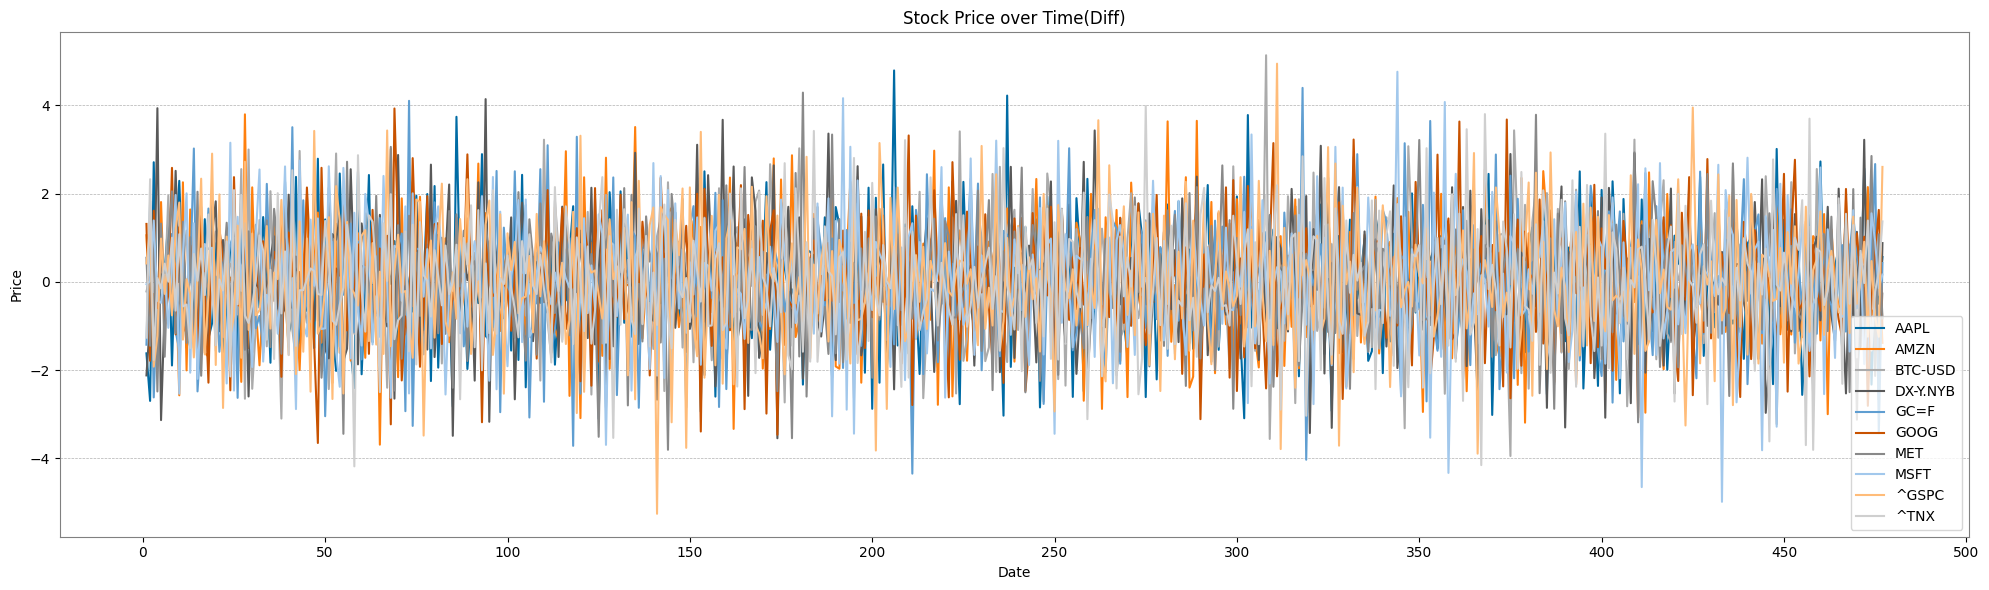

In [162]:
_temp = df_diff.columns
plot_stock_prices('Diff', df_diff, _temp)

In [173]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX
0,1.764052,0.400157,0.978738,2.240893,1.867558,-0.977278,0.950088,-0.151357,-0.103219,0.410599
1,0.144044,1.454274,0.761038,0.121675,0.443863,0.333674,1.494079,-0.205158,0.313068,-0.854096
2,-2.552990,0.653619,0.864436,-0.742165,2.269755,-1.454366,0.045759,-0.187184,1.532779,1.469359
3,0.154947,0.378163,-0.887786,-1.980796,-0.347912,0.156349,1.230291,1.202380,-0.387327,-0.302303
4,-1.048553,-1.420018,-1.706270,1.950775,-0.509652,-0.438074,-1.252795,0.777490,-1.613898,-0.212740
...,...,...,...,...,...,...,...,...,...,...
473,1.356787,2.014014,-1.372630,-0.857428,-1.681288,-0.150599,-0.721064,-1.940882,0.099905,1.281836
474,-0.970079,1.245377,0.696871,-0.064552,-1.057840,-0.469222,2.128395,-0.389241,0.569613,-0.274299
475,-1.098417,0.689721,1.649248,1.065133,1.609045,0.143017,-0.002557,0.527680,-0.222621,-0.491485
476,-1.593840,1.018373,0.049685,-1.601849,-1.818411,1.771657,1.075603,0.383403,-1.466997,-0.264782


In [163]:
df_main.columns

Index(['AAPL', 'AMZN', 'BTC-USD', 'DX-Y.NYB', 'GC=F', 'GOOG', 'MET', 'MSFT',
       '^GSPC', '^TNX'],
      dtype='object')

In [165]:
df_diff

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX
1,-1.620009,1.054116,-0.217700,-2.119218,-1.423695,1.310952,0.543991,-0.053801,0.416287,-1.264694
2,-2.697033,-0.800655,0.103398,-0.863840,1.825891,-1.788040,-1.448321,0.017974,1.219712,2.323455
3,2.707937,-0.275456,-1.752222,-1.238631,-2.617667,1.610715,1.184532,1.389564,-1.920106,-1.771662
4,-1.203500,-1.798180,-0.818484,3.931572,-0.161740,-0.594423,-2.483086,-0.424889,-1.226571,0.089562
5,0.153086,1.806920,1.195465,-3.131408,0.481470,0.866406,1.319313,-0.475018,0.979576,-0.150001
...,...,...,...,...,...,...,...,...,...,...
473,0.907618,2.145316,-0.621695,-2.135080,-2.430050,-2.807872,0.097543,-0.495731,-1.241858,1.387026
474,-2.326867,-0.768638,2.069501,0.792876,0.623448,-0.318624,2.849459,1.551642,0.469708,-1.556136
475,-0.128337,-0.555656,0.952377,1.129685,2.666885,0.612239,-2.130953,0.916921,-0.792234,-0.217186
476,-0.495423,0.328652,-1.599563,-2.666981,-3.427456,1.628640,1.078160,-0.144278,-1.244376,0.226703


In [172]:
df_diff.columns

Index(['AAPL', 'AMZN', 'BTC-USD', 'DX-Y.NYB', 'GC=F', 'GOOG', 'MET', 'MSFT',
       '^GSPC', '^TNX'],
      dtype='object')

In [174]:
diff_johansen_test = df_diff[['BTC-USD', 'GC=F', 'DX-Y.NYB', '^TNX', '^GSPC']]

In [180]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Johansen共和分検定を実行
johansen_test = coint_johansen(df_main, det_order=-1, k_ar_diff=1)

# 結果を整形して表示
def johansen_summary(johansen_test, alpha=0.05):
    output = pd.DataFrame({
        'Eigen': johansen_test.eig,
        'Trace Stat': johansen_test.lr1,
        'Max-Eig Stat': johansen_test.lr2,
        'Critical Trace 5%': johansen_test.cvt[:, 1],
        'Critical Max-Eig 5%': johansen_test.cvm[:, 1]
    }, index=['r <= ' + str(r) for r in range(johansen_test.eig.size)])
    
    # 有意水準に応じた臨界値のインデックスを取得
    crit_index = {0.1: 2, 0.05: 1, 0.01: 0}.get(alpha, 1)
    
    # 有意水準に応じた列を追加
    output['Signif Trace'] = output['Trace Stat'] > output['Critical Trace 5%']
    output['Signif Max-Eig'] = output['Max-Eig Stat'] > output['Critical Max-Eig 5%']
    
    return output

# 結果の要約
summary = johansen_summary(johansen_test)
summary

,Eigen,Trace Stat,Max-Eig Stat,Critical Trace 5%,Critical Max-Eig 5%,Signif Trace,Signif Max-Eig
r <= 0,0.436639,1994.050113,273.145293,219.4051,61.0404,True,True
r <= 1,0.404066,1720.904820,246.390005,179.5199,54.9629,True,True
r <= 2,0.389925,1474.514815,235.226658,143.6691,48.8795,True,True
r <= 3,0.372968,1239.288157,222.176819,111.7797,42.7679,True,True
r <= 4,0.350014,1017.111338,205.062661,83.9383,36.6301,True,True
r <= 5,0.320695,812.048677,184.062078,60.0627,30.4428,True,True
r <= 6,0.290588,627.986600,163.419779,40.1749,24.1592,True,True
r <= 7,0.287980,464.566820,161.673030,24.2761,17.7961,True,True
r <= 8,0.277177,302.893790,154.505493,12.3212,11.2246,True,True
r <= 9,0.267828,148.388297,148.388297,4.1296,4.1296,True,True


In [181]:
# 共和分ベクトルを取得（ここでは最初の共和分ベクトルを使用）
coint_vector = johansen_test.evec[:, 0]

# 各変数の価格データに共和分ベクトルの重みを適用して均衡価格を計算
# これは各変数の最新の価格データに共和分ベクトルの重みを掛け合わせたものの合計です
equilibrium_price = (df_main.iloc[-1] * coint_vector).sum()

print(f"Calculated Equilibrium Price: {equilibrium_price}")


Calculated Equilibrium Price: -0.5597652554277239


## VECM

In [192]:
df_main = df_base.copy()
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main.set_index('Date', inplace=True)
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
Date,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001


In [236]:
_temp = ['AAPL', 'AMZN', 'BTC-USD', 'DX-Y.NYB', 'GC=F', 'GOOG', 'MET', 'MSFT', '^GSPC', '^TNX']


In [196]:
from statsmodels.tsa.vector_ar.vecm import VECM

# DataFrameには既に定常性を持つ^TNXと定常性を持たない他のカラムが含まれているとします。
# ^VIX以外のカラムに対して1階差分を取る前に、^VIXを除外します。
# 元のデータフレームから1階差分を取る
df_diff = df_main.drop('^VIX', axis=1).diff().dropna()

# 差分を取った後のインデックスで^VIX列を取得
df_vix = df_main['^VIX'].loc[df_diff.index]

# 結合するためにDataFrameを再構成
df_vecm_ready = pd.concat([df_diff, df_vix], axis=1)

# VECMモデルをフィット
vecm_model = VECM(df_vecm_ready, k_ar_diff=2, coint_rank=1)
vecm_result = vecm_model.fit()

# VECMモデルの結果を表示
vecm_result.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.AAPL,-0.9059,0.065,-13.979,0.000,-1.033,-0.779
L1.AMZN,0.1696,0.047,3.639,0.000,0.078,0.261
L1.BTC-USD,-0.0001,8.48e-05,-1.249,0.212,-0.000,6.03e-05
L1.DX-Y.NYB,-0.2995,0.188,-1.596,0.111,-0.667,0.068
L1.GC=F,-0.0071,0.006,-1.195,0.232,-0.019,0.005
L1.GOOG,-0.4447,0.086,-5.186,0.000,-0.613,-0.277
L1.MET,0.8849,0.146,6.057,0.000,0.599,1.171
L1.MSFT,0.4351,0.048,9.091,0.000,0.341,0.529
L1.^GSPC,-0.0091,0.006,-1.526,0.127,-0.021,0.003
L1.^TNX,-2.4281,1.738,-1.397,0.162,-5.835,0.979


In [197]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX
Date,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001


In [198]:
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank

# VECMモデルのオーダーを選択
# この関数はAIC、BIC、FPE、HQICの各情報基準を計算し、最適なラグの長さを提案します。
order = select_order(data=df_vecm_ready, maxlags=10, deterministic='n')
print(order.summary())

# 共和分ランクの選択
# この関数は、与えられたデータに対する共和分のランクを選択するための様々なテストを実行します。
rank_test = select_coint_rank(df_vecm_ready, det_order=-1, k_ar_diff=order.aic, method='trace', signif=0.05)
print(rank_test.summary())

# 最適なオーダーと共和分ランクを用いたVECMモデルのフィッティング
vecm_model = VECM(df_vecm_ready, k_ar_diff=order.aic, coint_rank=rank_test.rank)
vecm_result = vecm_model.fit()
vecm_result.summary()

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       36.68*      37.86*  8.552e+15*      37.15*
1        36.73       38.98   8.950e+15       37.62
2        36.86       40.18   1.017e+16       38.16
3        36.89       41.29   1.056e+16       38.62
4        37.04       42.52   1.232e+16       39.19
5        37.04       43.59   1.246e+16       39.62
6        37.20       44.83   1.481e+16       40.20
7        37.32       46.02   1.694e+16       40.74
8        37.36       47.15   1.817e+16       41.21
9        37.46       48.32   2.058e+16       41.73
10       37.52       49.46   2.267e+16       42.22
--------------------------------------------------
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0  11          3851.          263.3
  1  11          3279.          219.4
 

,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-1.1416,0.073,-15.618,0.000,-1.285,-0.998
ec2,0.1472,0.054,2.732,0.006,0.042,0.253
ec3,0.0002,8.76e-05,1.797,0.072,-1.43e-05,0.000
ec4,-0.0412,0.206,-0.200,0.842,-0.445,0.362
ec5,0.0029,0.007,0.438,0.662,-0.010,0.016
ec6,-0.2603,0.090,-2.898,0.004,-0.436,-0.084
ec7,0.2545,0.155,1.640,0.101,-0.050,0.559
ec8,0.1629,0.045,3.595,0.000,0.074,0.252
ec9,-0.0106,0.006,-1.655,0.098,-0.023,0.002
ec10,-1.4773,1.985,-0.744,0.457,-5.368,2.414


# VAR

In [235]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,returns
Date,,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000,NaN
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000,-0.003637
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000,-0.008269
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000,-0.006563
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999,-0.045846
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001,0.011023
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999,0.008758
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001,-0.035803


In [240]:
df_main

,AAPL,AMZN,BTC-USD,DX-Y.NYB,GC=F,GOOG,MET,MSFT,^GSPC,^TNX,^VIX,returns
Date,,,,,,,,,,,,
2014-09-21,25.395000,16.200001,457.334015,84.699997,1234.400024,29.158445,49.269161,46.520000,2001.569946,2.600,12.650000,NaN
2014-09-28,25.264999,16.225000,402.152008,84.669998,1216.800049,29.288090,49.215687,47.060001,1994.290039,2.566,13.690000,-0.003637
2014-10-05,25.027500,16.091000,375.467010,85.589996,1217.500000,28.739098,48.048126,46.439999,1977.800049,2.491,15.980000,-0.008269
2014-10-12,24.905001,16.110001,330.079010,85.709999,1206.699951,28.788462,47.228165,46.090000,1964.819946,2.425,15.460000,-0.006563
2014-10-19,24.952499,15.322500,390.414001,85.430000,1229.300049,26.587503,43.645275,43.650002,1874.739990,2.286,24.639999,-0.045846
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-15,178.990005,128.259995,27583.677734,106.080002,1849.500000,139.500000,61.900002,329.820007,4335.660156,4.797,17.700001,0.011023
2023-10-22,178.720001,132.550003,28519.466797,106.239998,1921.099976,140.490005,63.349998,332.640015,4373.629883,4.712,17.209999,0.008758
2023-10-29,173.000000,126.559998,33086.234375,105.540001,1976.300049,137.899994,58.490002,329.320007,4217.040039,4.838,20.370001,-0.035803


In [241]:
_temp = ['BTC-USD', 'DX-Y.NYB', 'GC=F', '^GSPC', '^TNX']
df_var = df_main[_temp]

df_var

,BTC-USD,DX-Y.NYB,GC=F,^GSPC,^TNX
Date,,,,,
2014-09-21,457.334015,84.699997,1234.400024,2001.569946,2.600
2014-09-28,402.152008,84.669998,1216.800049,1994.290039,2.566
2014-10-05,375.467010,85.589996,1217.500000,1977.800049,2.491
2014-10-12,330.079010,85.709999,1206.699951,1964.819946,2.425
2014-10-19,390.414001,85.430000,1229.300049,1874.739990,2.286
...,...,...,...,...,...
2023-10-15,27583.677734,106.080002,1849.500000,4335.660156,4.797
2023-10-22,28519.466797,106.239998,1921.099976,4373.629883,4.712
2023-10-29,33086.234375,105.540001,1976.300049,4217.040039,4.838


In [242]:
df_results = perform_adf_test_on_dataframe(df_var.copy())
display(df_results)

,ADF Test Statistic,P-Value,# Lags Used,# Observations,Result,Critical Value (1%),Critical Value (5%),Critical Value (10%)
BTC-USD,-1.255666,0.649203,0,477,Not Stationary,-3.444134,-2.867618,-2.570008
DX-Y.NYB,-2.450632,0.127953,1,476,Not Stationary,-3.444163,-2.867631,-2.570014
GC=F,-0.644148,0.860691,1,476,Not Stationary,-3.444163,-2.867631,-2.570014
^GSPC,-0.78606,0.823182,0,477,Not Stationary,-3.444134,-2.867618,-2.570008
^TNX,-0.012315,0.957502,0,477,Not Stationary,-3.444134,-2.867618,-2.570008


In [244]:
import pandas as pd
from statsmodels.tsa.api import VAR

model = VAR(df_var)

In [245]:
_temp = model.select_order(maxlags=3).summary()
_temp

,AIC,BIC,FPE,HQIC
0,42.83,42.87,3.979e+18,42.84
1,25.81*,26.07*,1.619e+11*,25.91*
2,25.87,26.35,1.716e+11,26.06
3,25.92,26.62,1.803e+11,26.19


In [246]:
_result = model.fit(2)

In [247]:
_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Nov, 2023
Time:                     16:57:08
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    26.3406
Nobs:                     476.000    HQIC:                   26.0486
Log likelihood:          -9476.60    FPE:                1.70056e+11
AIC:                      25.8593    Det(Omega_mle):     1.51698e+11
--------------------------------------------------------------------
Results for equation BTC-USD
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            1796.451005      2180.385024            0.824           0.410
L1.BTC-USD          1.003820         0.048419           20.732           0.000
L1.DX-Y.NYB        10.726391       114.429404            0.094    

In [248]:
from copy import deepcopy

def causality_vs_each(data, model):
    columns = data.columns.tolist()

    for i in range(len(columns)):
        vs = deepcopy(columns)
        tv = vs.pop(i)
        for v in vs:
            result = model.test_causality(tv, v, kind='f')
            print(result.summary())

In [249]:
causality_vs_each(df_var, _result)

Granger causality F-test. H_0: DX-Y.NYB does not Granger-cause BTC-USD. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.087          3.000   0.337 (2, 2325)
-----------------------------------------------
Granger causality F-test. H_0: GC=F does not Granger-cause BTC-USD. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.066          3.000   0.345 (2, 2325)
-----------------------------------------------
Granger causality F-test. H_0: ^GSPC does not Granger-cause BTC-USD. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.7481          3.000   0.473 (2, 2325)
-----------------------------------------------
Granger causality F-test. H_0: ^TNX does not